Scoring in next 10 actions model - Model Evaluation - GBM

In [1]:
import pandas as pd
import numpy as np
import joblib

import warnings
warnings.filterwarnings('ignore')

from expected_vaep_model.config import exp_vaep_chain_output_path, exp_vaep_modelling_file_path
from expected_vaep_model.modelling_data_contract import ModellingDataContract
from expected_vaep_model.visualization.model_evaluation import XGBRegressorEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

New Model

In [2]:
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/models/models/exp_vaep_scores_v5.joblib"
data_file_path = exp_vaep_chain_output_path

Load Data

In [3]:
evaluation_data = pd.read_csv(data_file_path)
evaluation_data = evaluation_data[~evaluation_data['exp_vaep_value'].isnull()]

In [5]:
modelling_data = pd.read_csv(exp_vaep_modelling_file_path)
modelling_data = modelling_data[['match_id', 'chain_number', 'order', 'exp_scoresTrainingSet', 'exp_scoresTestSet', 'exp_scoresValidationSet', 'exp_concedesTrainingSet', 'exp_concedesTestSet', 'exp_concedesValidationSet']]
evaluation_data = evaluation_data.merge(modelling_data, how = "left", on = ['match_id', 'chain_number', 'order'])

In [6]:
evaluation_data = evaluation_data.replace({'True':True, 'False':False})

In [7]:
evaluation_data.head()

Chain_Number Initial_State Final_State  Order  Quarter  \
0             1  centreBounce        goal    2.0        1   
1             1  centreBounce        goal    3.0        1   
2             1  centreBounce        goal    4.0        1   
3             1  centreBounce        goal    5.0        1   
4             1  centreBounce        goal    6.0        1   

   Quarter_Duration_Chain_Start  Quarter_Duration      Team_Chain  \
0                            13              24.0  Brisbane Lions   
1                            13              24.0  Brisbane Lions   
2                            13              28.0  Brisbane Lions   
3                            13              29.0  Brisbane Lions   
4                            13              30.0  Brisbane Lions   

             Team          Player AFL_API_Player_ID        Description     x  \
0  Brisbane Lions     Dayne Zorko       Dayne_Zorko      Hard Ball Get   8.0   
1  Brisbane Lions     Dayne Zorko       Dayne_Zorko           Handball   9.0   
2          Sydney  Oliver Florent    Oliver_Florent     Loose Ball Get  11.0   
3          Sydney  Oliver Florent    Oliver_Florent           Handball  12.0   
4          Sydney   George Hewett     George_Hewett  Handball Received  14.0   

     y     Disposal Shot_At_Goal Behind_Detail  Venue_Width  Venue_Length  \
0 -5.0          NaN          NaN           NaN          138           156   
1 -6.0  ineffective          NaN           NaN          138           156   
2 -7.0          NaN          NaN           NaN          138           156   
3 -5.0    effective          NaN           NaN          138           156   
4 -2.0          NaN          NaN           NaN          138           156   

        Home_Team Away_Team Home_Team_Direction_Q1  \
0  Brisbane Lions    Sydney                  right   
1  Brisbane Lions    Sydney                  right   
2  Brisbane Lions    Sydney                  right   
3  Brisbane Lions    Sydney                  right   
4  Brisbane Lions    Sydney                  right   

                      Match_ID Round_ID    Year  Season  Goal  Behind  Miss  \
0  202101_BrisbaneLions_Sydney   202101  2021.0     NaN   NaN     NaN     0   
1  202101_BrisbaneLions_Sydney   202101  2021.0     NaN   NaN     NaN     0   
2  202101_BrisbaneLions_Sydney   202101  2021.0     NaN   NaN     NaN     0   
3  202101_BrisbaneLions_Sydney   202101  2021.0     NaN   NaN     NaN     0   
4  202101_BrisbaneLions_Sydney   202101  2021.0     NaN   NaN     NaN     0   

   Score     Event_Type1  ballUp  centreBounce  kickIn  possGain  throwIn  \
0      0   Centre Bounce   False          True   False     False    False   
1      0   Hard Ball Get   False          True   False     False    False   
2      0        Handball   False          True   False     False    False   
3      0  Loose Ball Get   False          True   False     False    False   
4      0        Handball   False          True   False     False    False   

         Event_Type0     Event_Type2    Event_Type3    x0    x1    x2   x3  \
0      Hard Ball Get             NaN            NaN   8.0   0.0   NaN  NaN   
1           Handball   Centre Bounce            NaN   9.0   8.0   0.0  NaN   
2     Loose Ball Get   Hard Ball Get  Centre Bounce  11.0   9.0   8.0  0.0   
3           Handball        Handball  Hard Ball Get  12.0  11.0   9.0  8.0   
4  Handball Received  Loose Ball Get       Handball  14.0  12.0  11.0  9.0   

    y0   y1   y2   y3  Quarter_Duration0  Quarter_Duration1  \
0 -5.0  0.0  NaN  NaN               24.0               13.0   
1 -6.0 -5.0  0.0  NaN               24.0               24.0   
2 -7.0 -6.0 -5.0  0.0               28.0               24.0   
3 -5.0 -7.0 -6.0 -5.0               29.0               28.0   
4 -2.0 -5.0 -7.0 -6.0               30.0               29.0   

   Quarter_Duration2  Quarter_Duration3  Time_Since_Last_Action  \
0                NaN                NaN                    11.0   
1               13.0            

In [8]:
scores_training_eval_data = evaluation_data[(evaluation_data['exp_scoresTrainingSet']) | (evaluation_data['exp_scoresValidationSet'])]
scores_test_eval_data = evaluation_data[(evaluation_data['exp_scoresTestSet'])]

concedes_training_eval_data = evaluation_data[(evaluation_data['exp_concedesTrainingSet']) | (evaluation_data['exp_concedesValidationSet'])]
concedes_test_eval_data = evaluation_data[(evaluation_data['exp_concedesTestSet'])]

Load Models

In [9]:
scores_xgb = joblib.load("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/models/models/exp_vaep_scores_v5.joblib")
concedes_xgb = joblib.load("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/models/models/exp_vaep_concedes_v5.joblib")

Evaluate Model

In [10]:
scores_train_evals = XGBRegressorEvaluator(model = scores_xgb,
                                       data = scores_training_eval_data,
                                       actual_name = "exp_scores_label",
                                       expected_name = "exp_scores"
                                       )


In [11]:
scores_test_evals = XGBRegressorEvaluator(model = scores_xgb,
                                       data = scores_test_eval_data,
                                       actual_name = "exp_scores_label",
                                       expected_name = "exp_scores"
                                       )

In [12]:
concedes_train_evals = XGBRegressorEvaluator(model = concedes_xgb,
                                       data = concedes_training_eval_data,
                                       actual_name = "exp_concedes_label",
                                       expected_name = "exp_concedes"
                                       )

In [13]:
concedes_test_evals = XGBRegressorEvaluator(model = concedes_xgb,
                                       data = concedes_test_eval_data,
                                       actual_name = "exp_concedes_label",
                                       expected_name = "exp_concedes"
                                       )

Model Averages

In [14]:
scores_training_eval_data[['exp_scores_label', 'exp_scores']].describe()

exp_scores_label     exp_scores
count     766156.000000  766156.000000
mean           0.847067       0.851171
std            1.547840       0.928680
min            0.000000       0.000000
25%            0.000000       0.158667
50%            0.000000       0.542493
75%            1.643831       1.240359
max            5.777211       6.000000

In [15]:
scores_test_eval_data[['exp_scores_label', 'exp_scores']].describe()

exp_scores_label     exp_scores
count     191540.000000  191540.000000
mean           0.844010       0.849727
std            1.547740       0.926204
min            0.000000       0.000000
25%            0.000000       0.158507
50%            0.000000       0.541978
75%            1.581476       1.237027
max            5.777211       6.000000

In [16]:
concedes_training_eval_data[['exp_concedes_label', 'exp_concedes']].describe()

exp_concedes_label   exp_concedes
count       766156.000000  766156.000000
mean             0.180725       0.191358
std              0.781516       0.263097
min              0.000000       0.000000
25%              0.000000       0.056964
50%              0.000000       0.096064
75%              0.000000       0.214346
max              5.777211       3.448747

In [17]:
concedes_test_eval_data[['exp_concedes_label', 'exp_concedes']].describe()

exp_concedes_label   exp_concedes
count       191540.000000  191540.000000
mean             0.180728       0.190761
std              0.783173       0.263714
min              0.000000       0.000000
25%              0.000000       0.056844
50%              0.000000       0.095885
75%              0.000000       0.213787
max              5.777211       3.448747

Plots

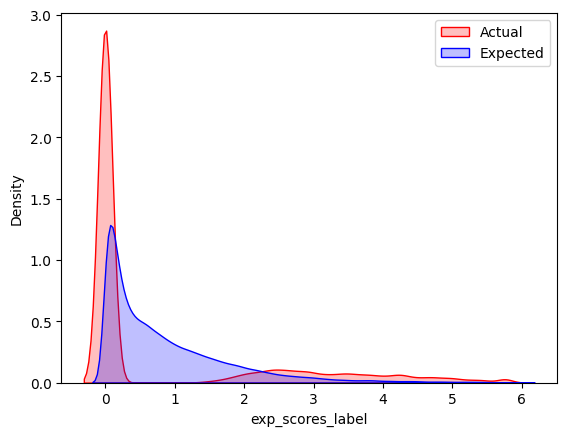

In [18]:
scores_train_evals.plot_distribution()

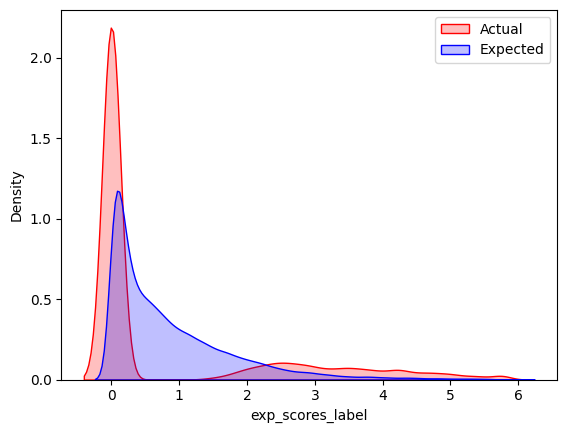

In [19]:
scores_test_evals.plot_distribution()

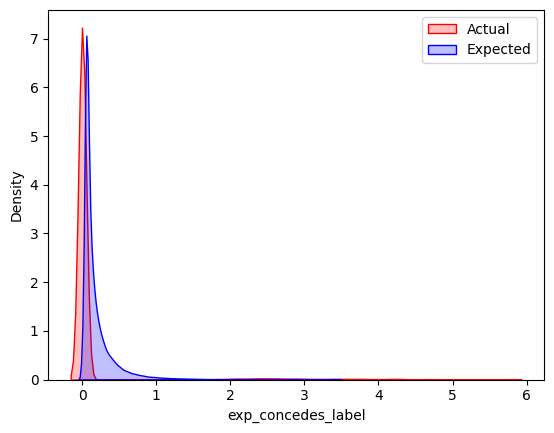

In [20]:
concedes_train_evals.plot_distribution()

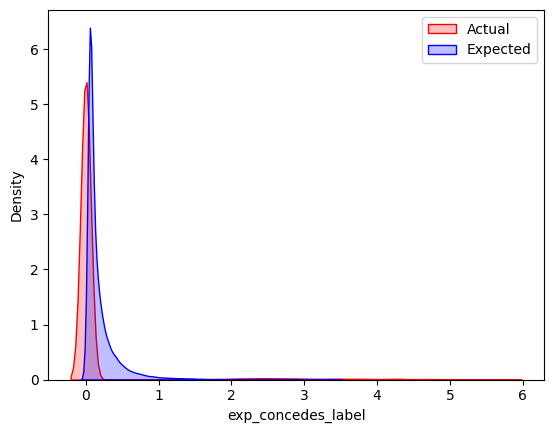

In [21]:
concedes_test_evals.plot_distribution()

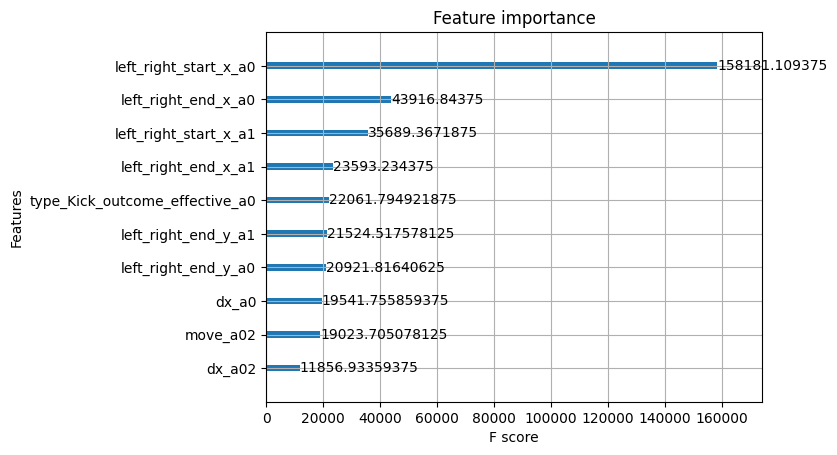

In [22]:
scores_train_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

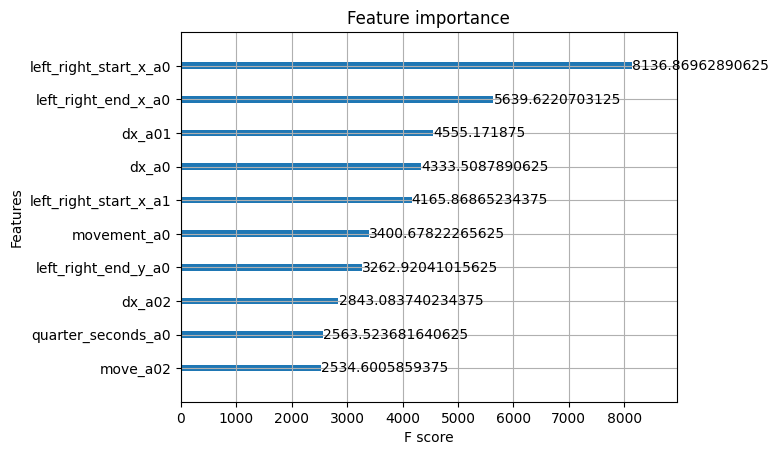

In [23]:
concedes_train_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

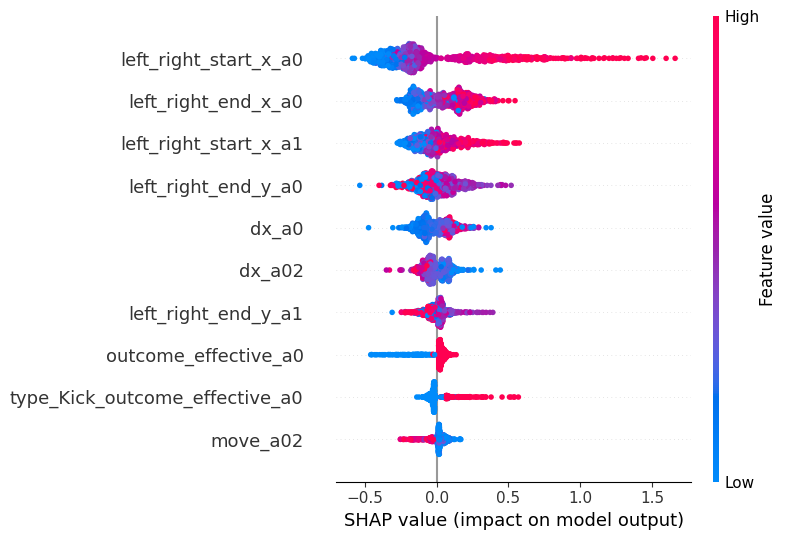

In [24]:
scores_train_evals.plot_shap_summary_plot(sample=1000)

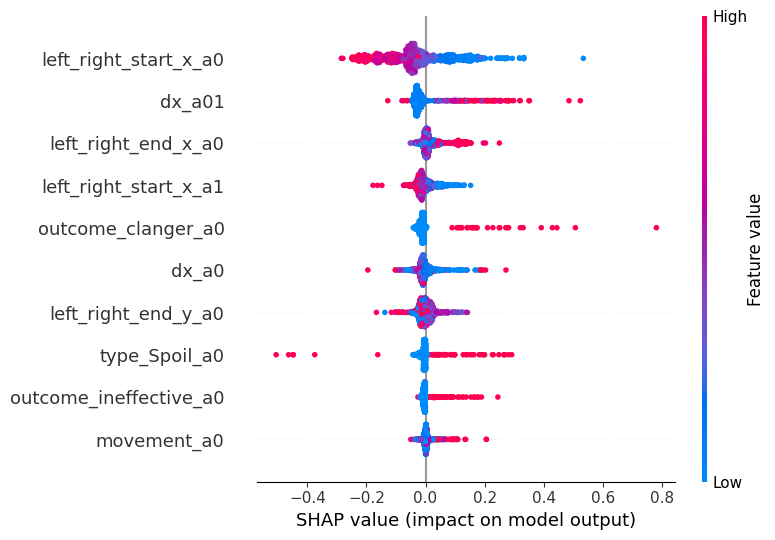

In [25]:
concedes_train_evals.plot_shap_summary_plot(sample=1000)

In [26]:
top_features = scores_test_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['left_right_start_x_a0',
 'left_right_end_x_a0',
 'left_right_start_x_a1',
 'left_right_end_y_a0',
 'dx_a0',
 'dx_a02',
 'outcome_effective_a0',
 'type_Kick_outcome_effective_a0',
 'left_right_end_y_a1',
 'move_a02']

In [27]:
# for col in top_10_features:
#     scores_test_evals.plot_pdp([col])

In [28]:
# for col in top_10_features:
#     scores_train_evals.plot_ice([col])
#     scores_test_evals.plot_ice([col])

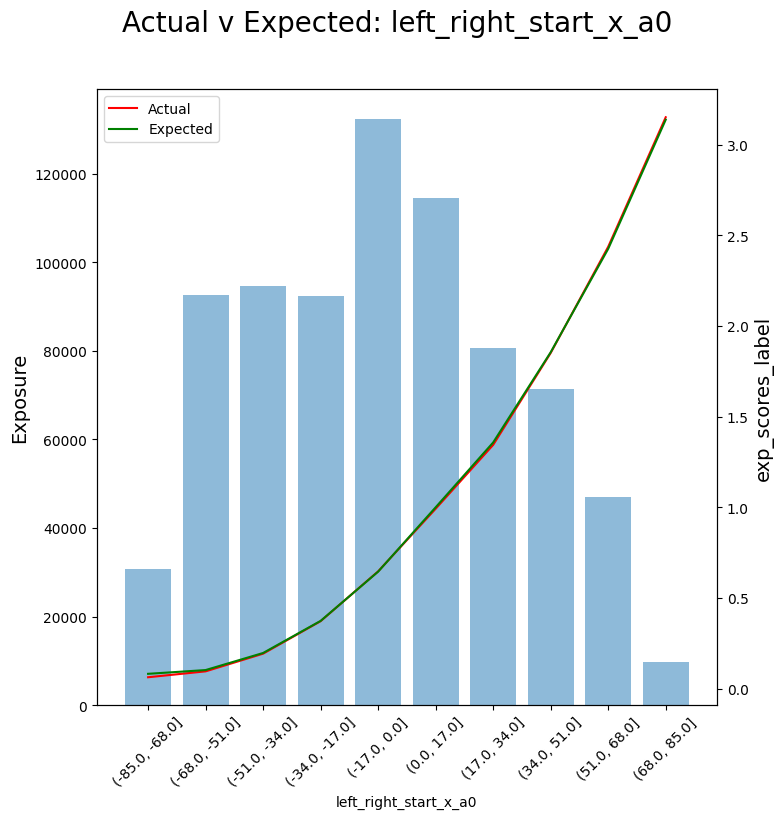

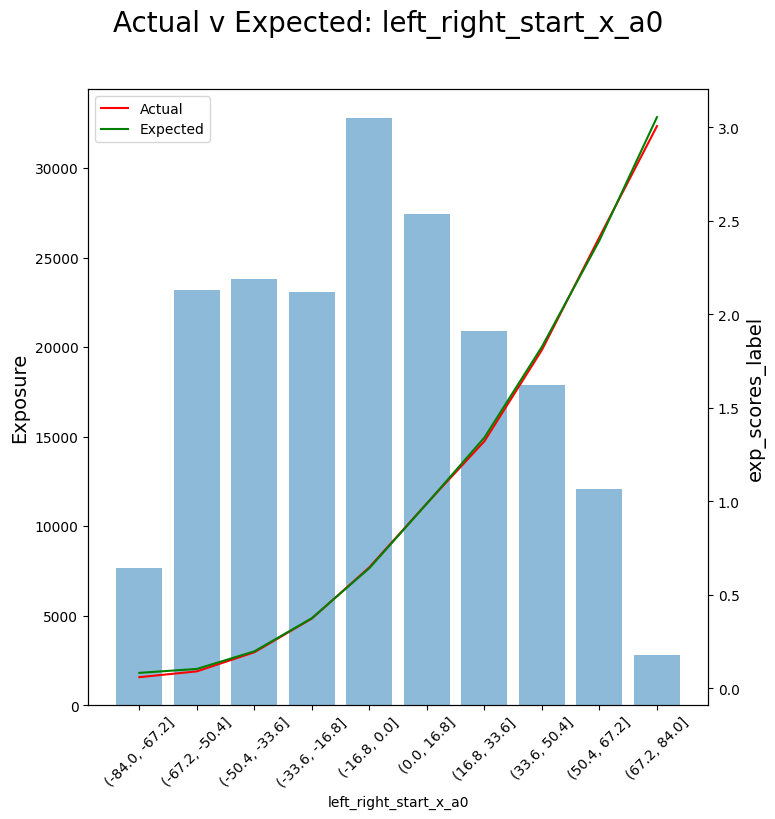

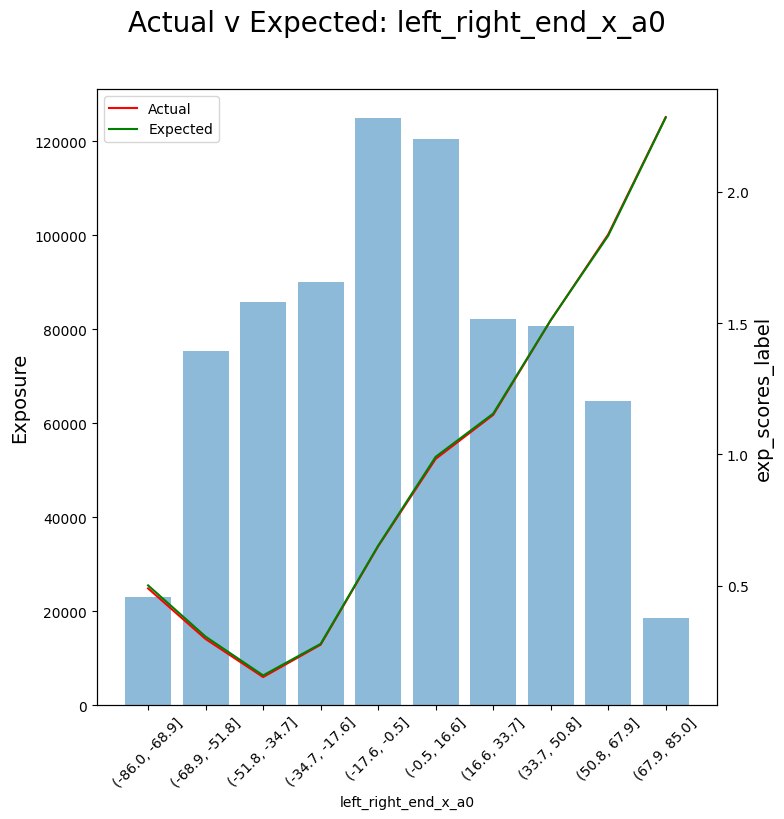

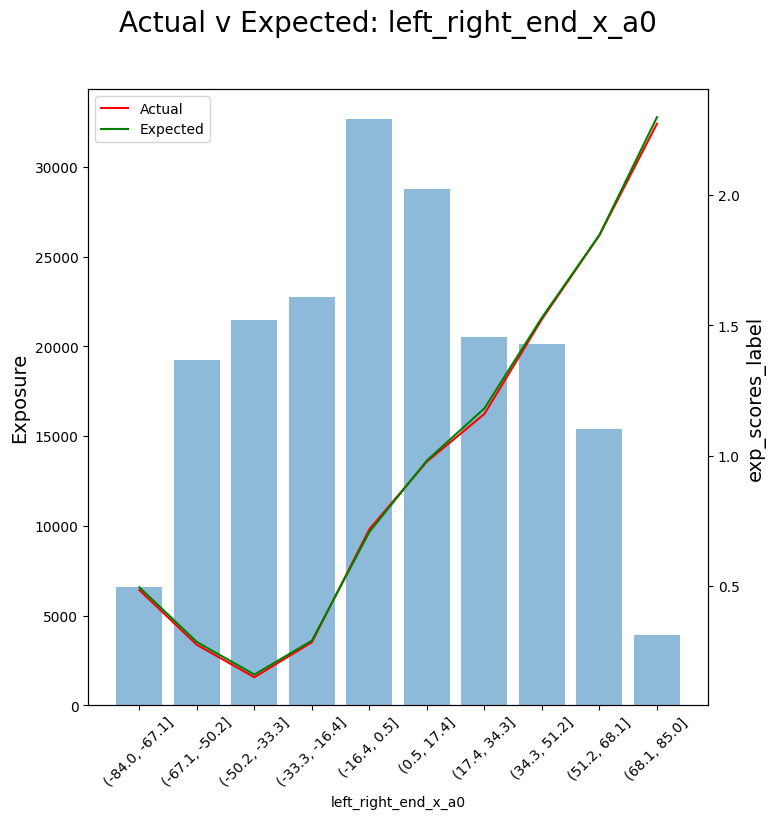

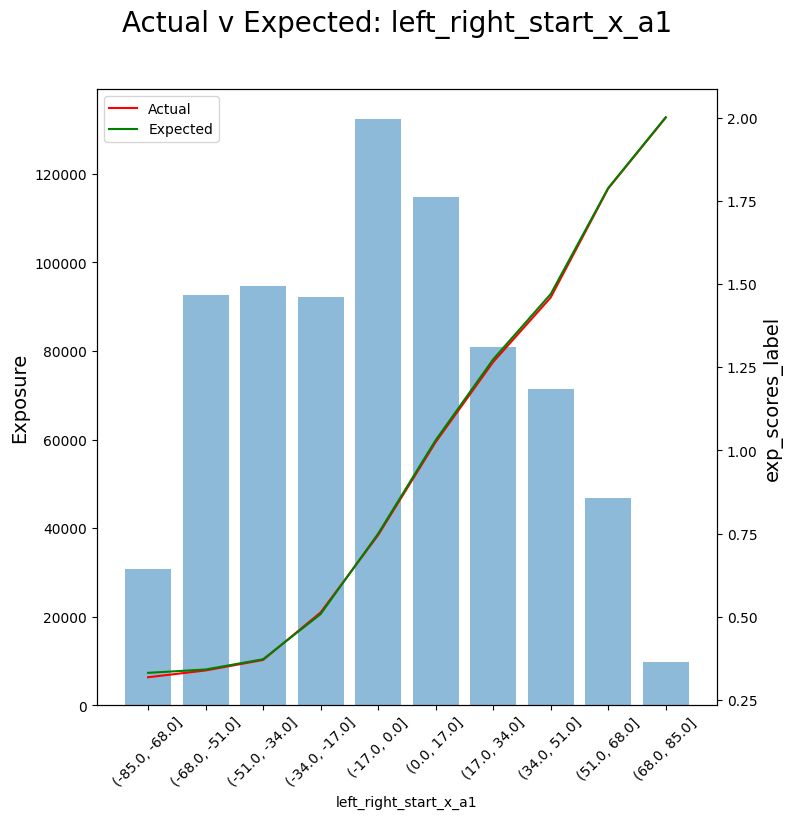

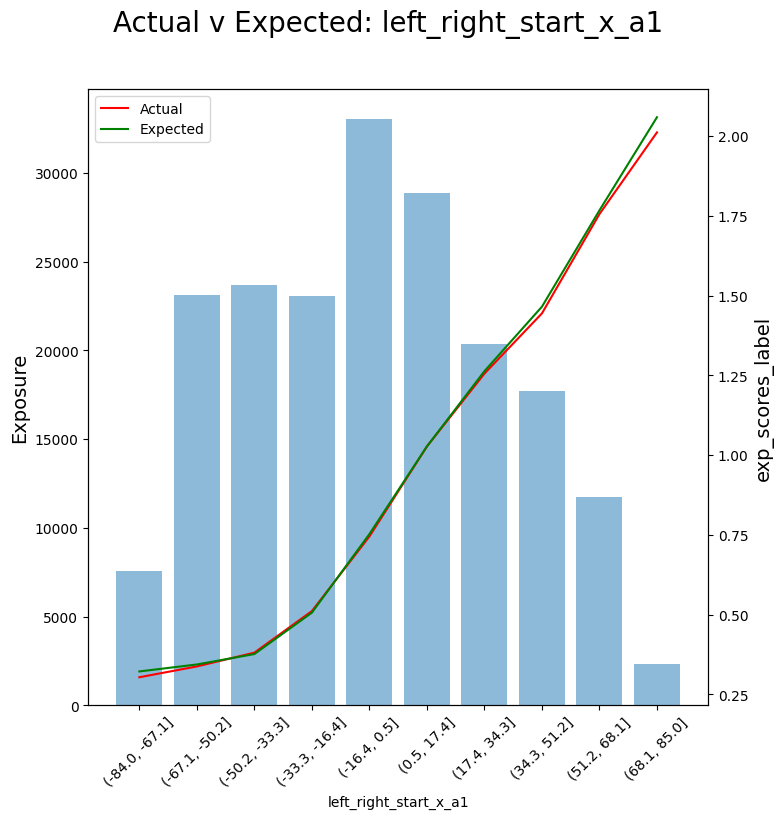

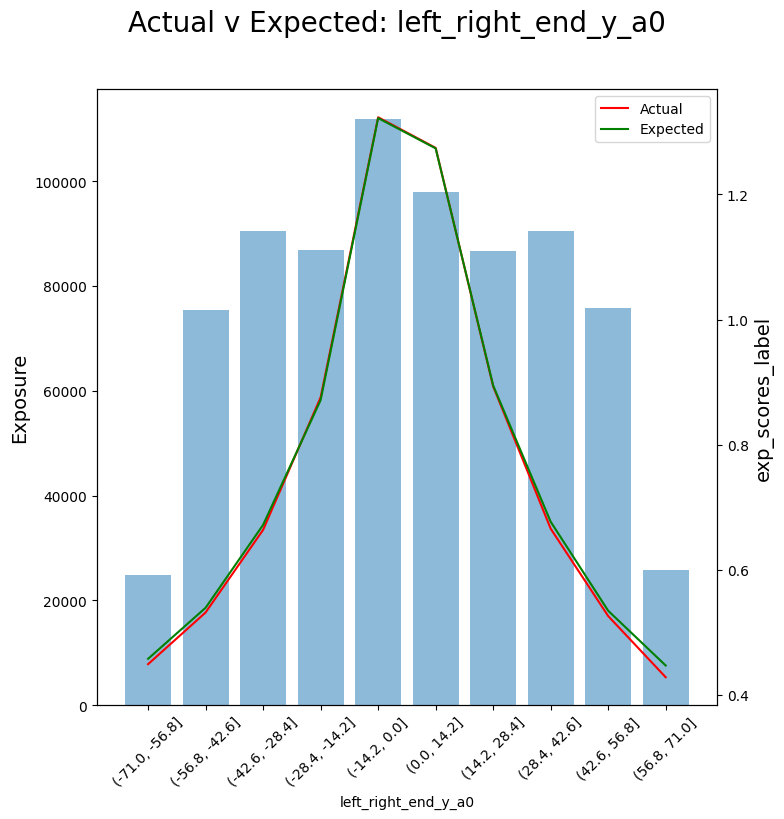

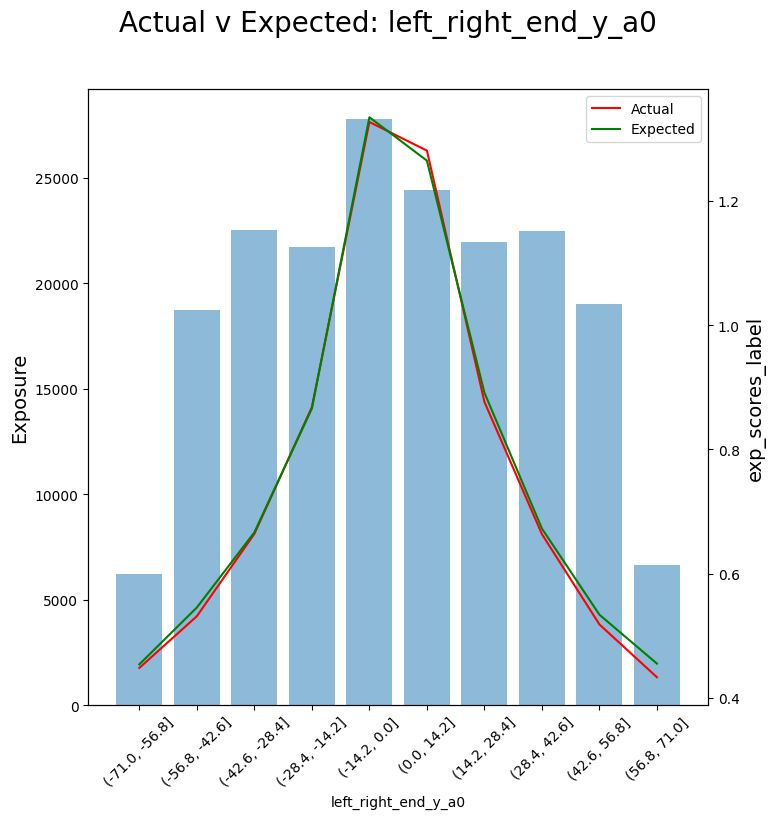

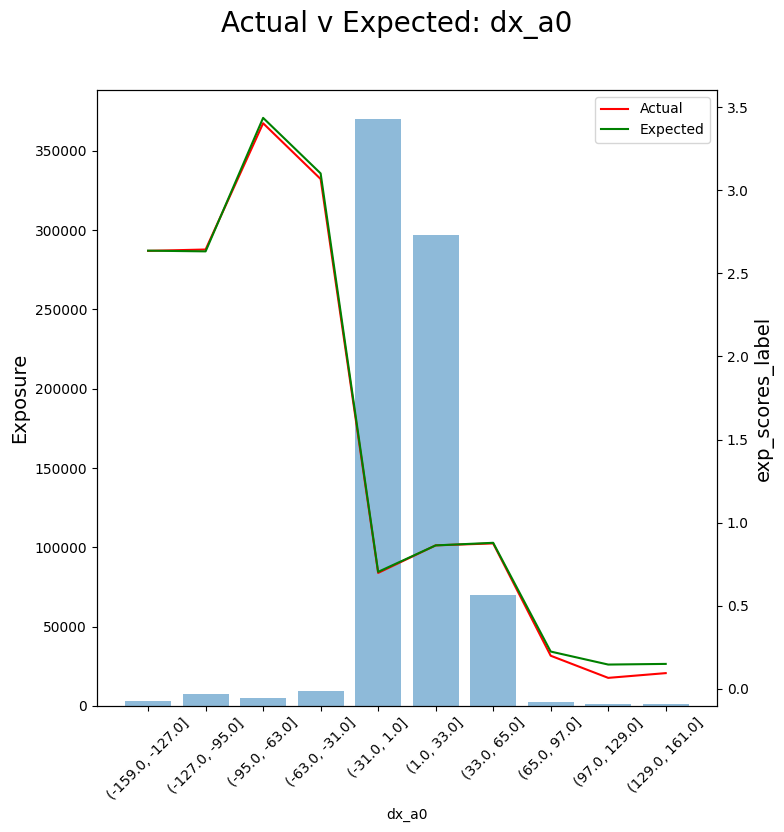

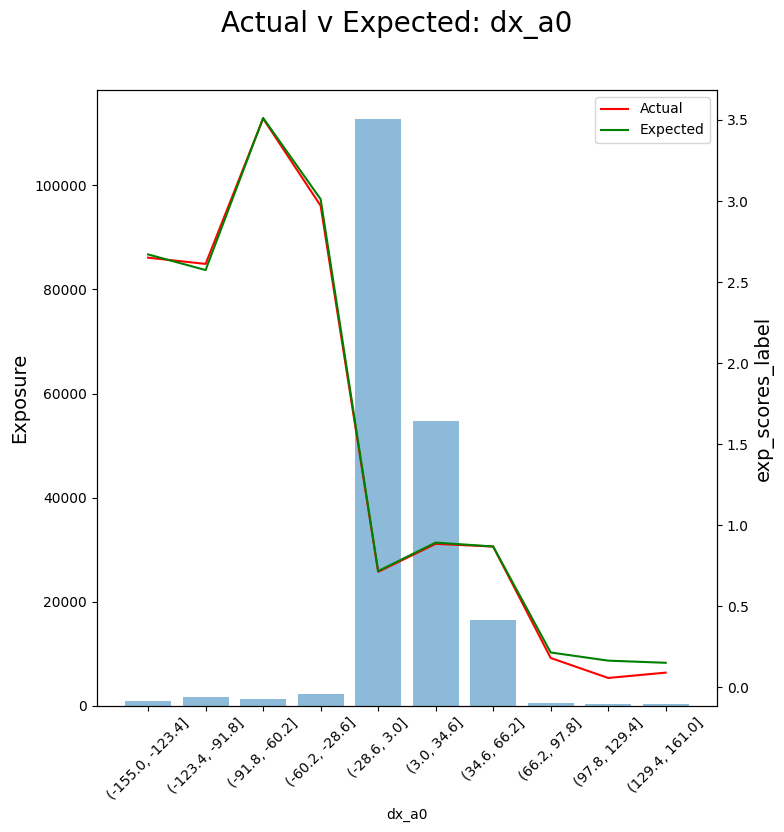

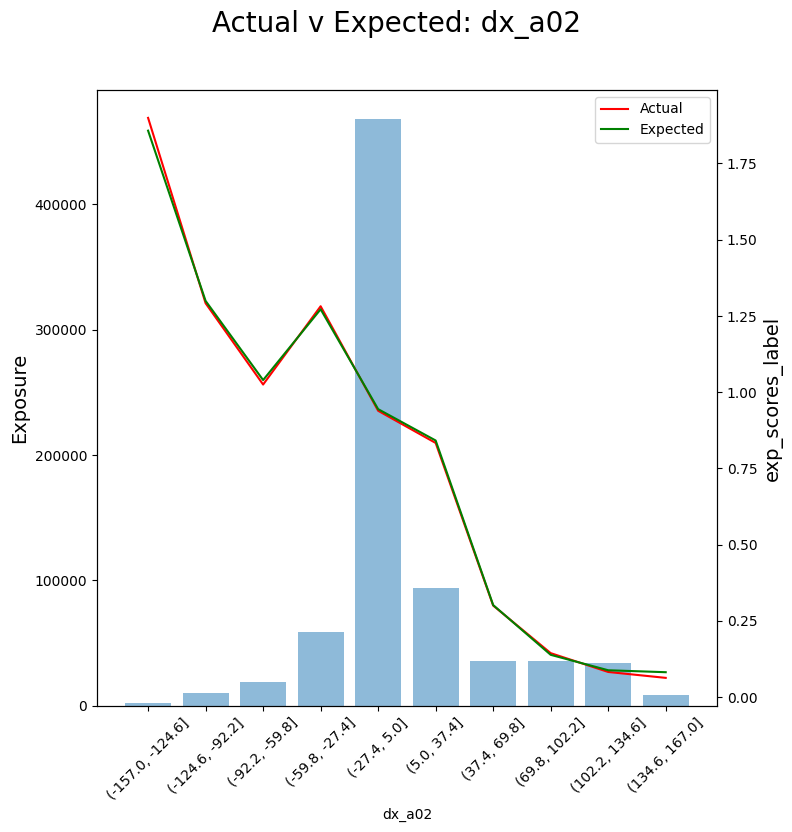

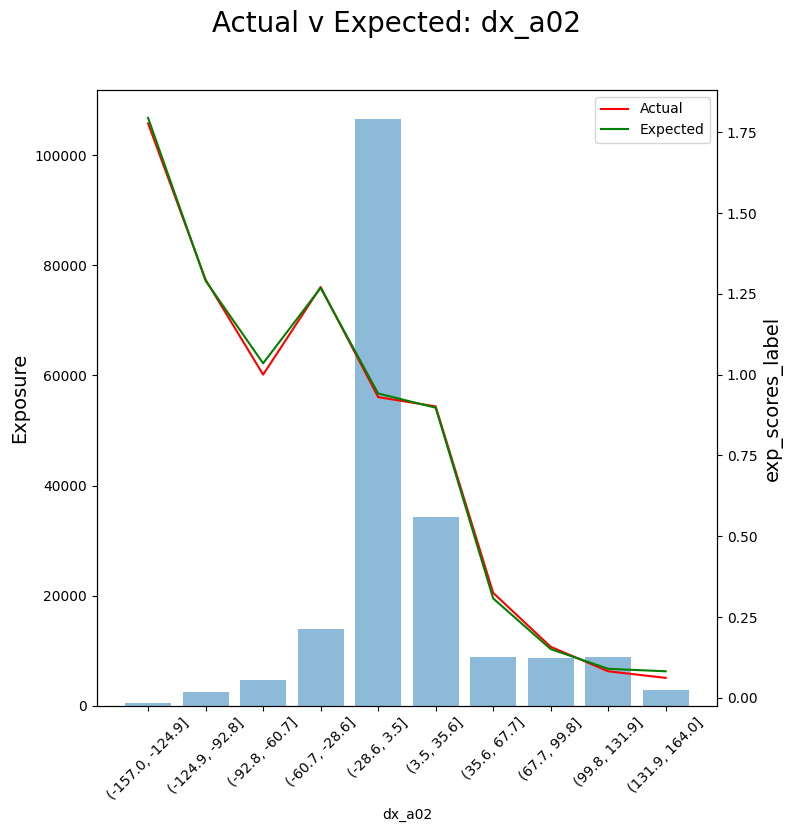

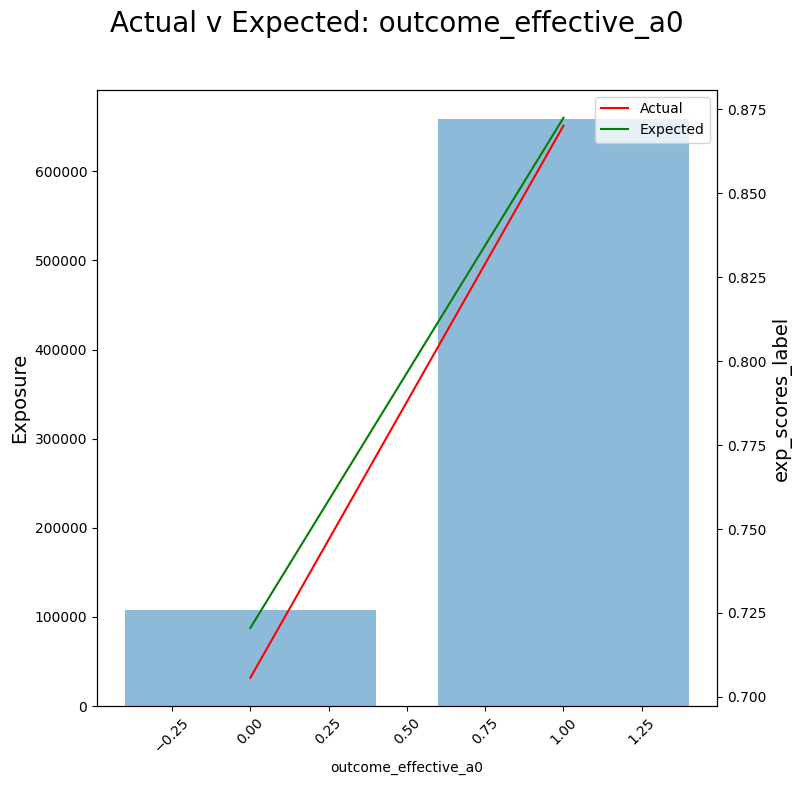

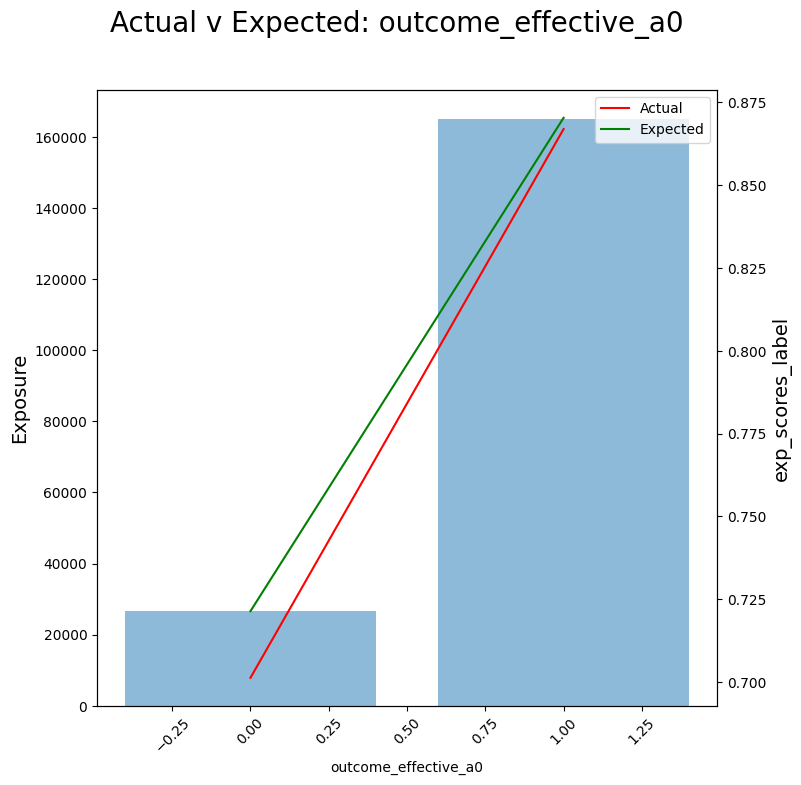

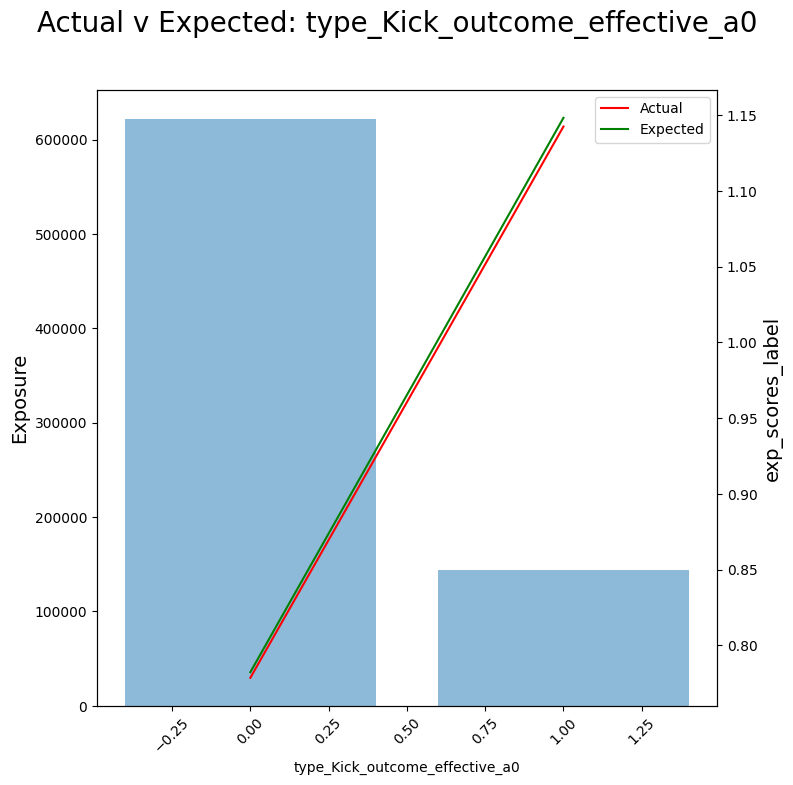

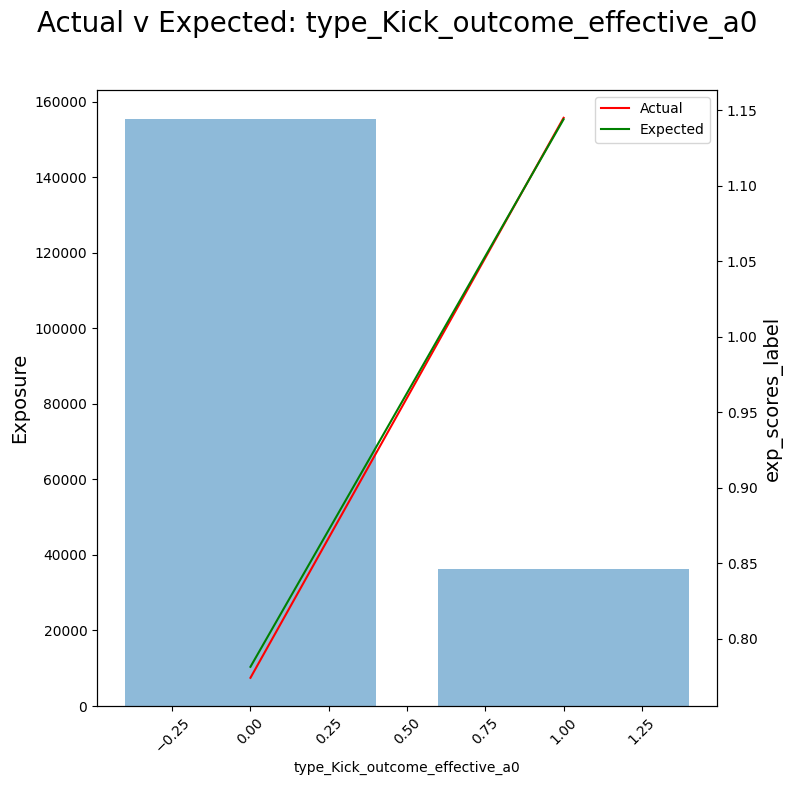

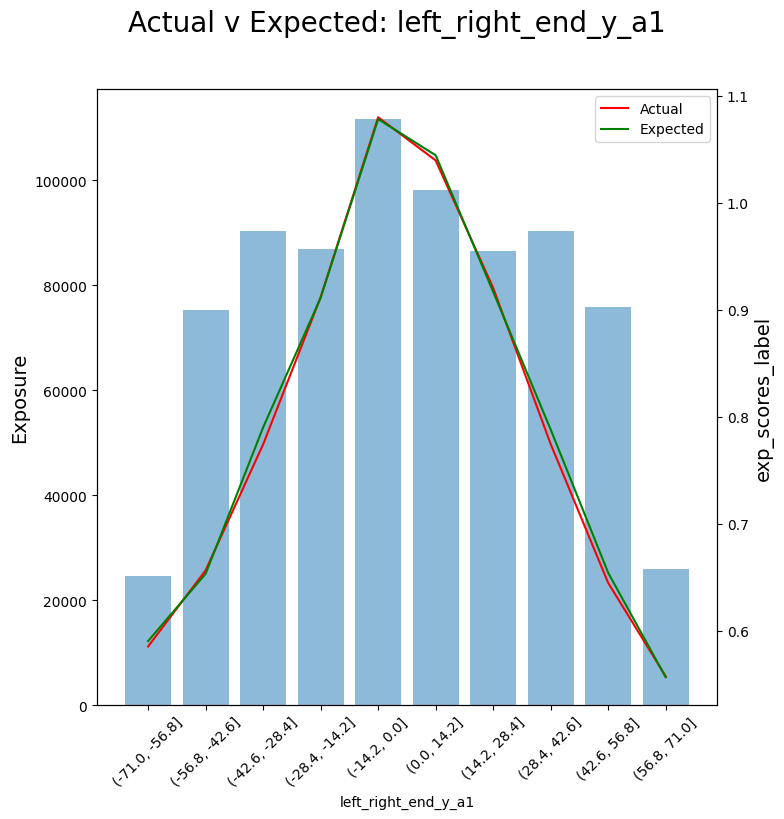

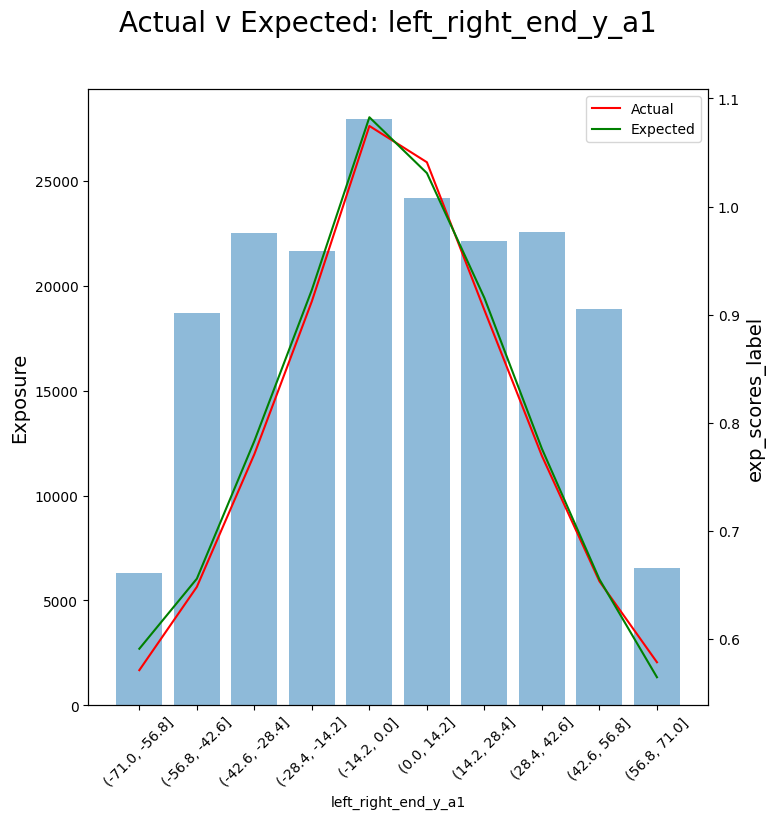

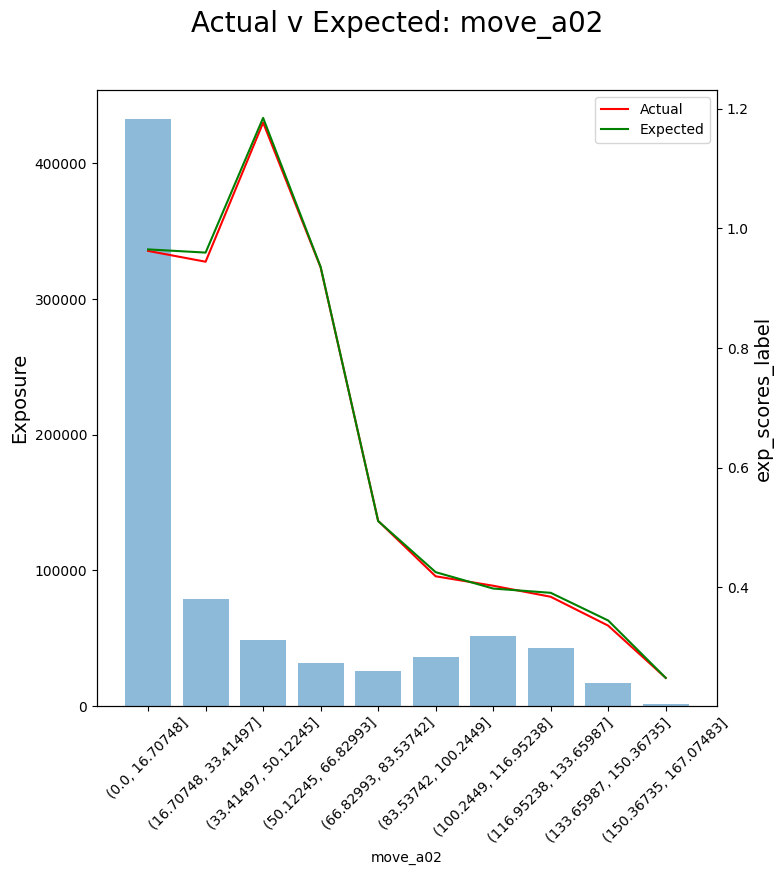

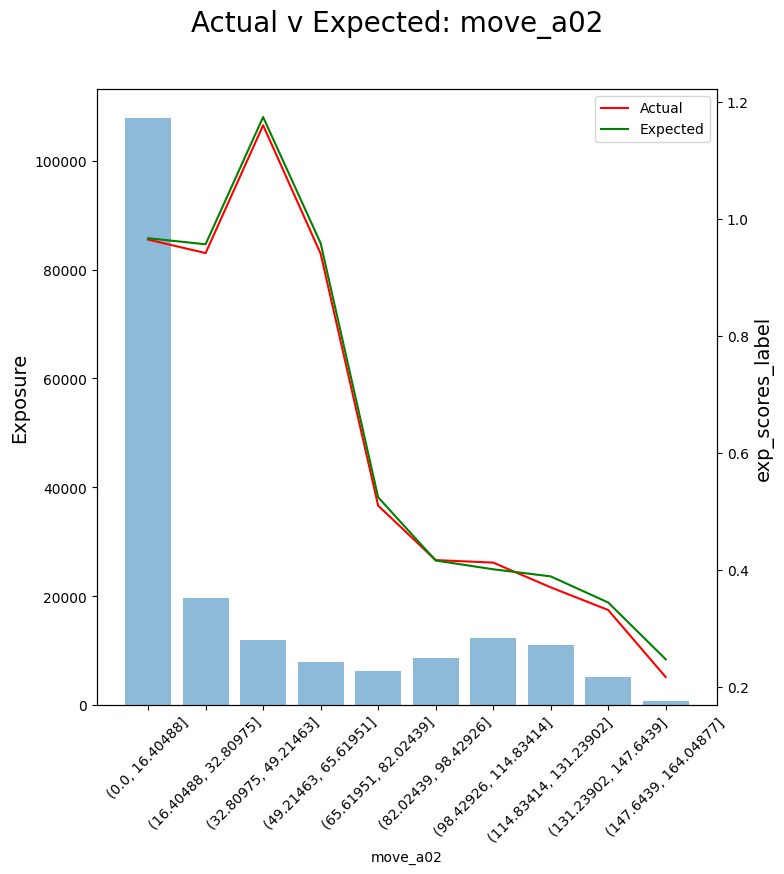

In [29]:
for col in top_10_features:
    scores_train_evals.plot_feature_ave(col)
    scores_test_evals.plot_feature_ave(col)

In [30]:
top_features = concedes_test_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['left_right_start_x_a0',
 'dx_a01',
 'left_right_end_x_a0',
 'left_right_start_x_a1',
 'outcome_clanger_a0',
 'dx_a0',
 'left_right_end_y_a0',
 'type_Spoil_a0',
 'movement_a0',
 'dx_a02']

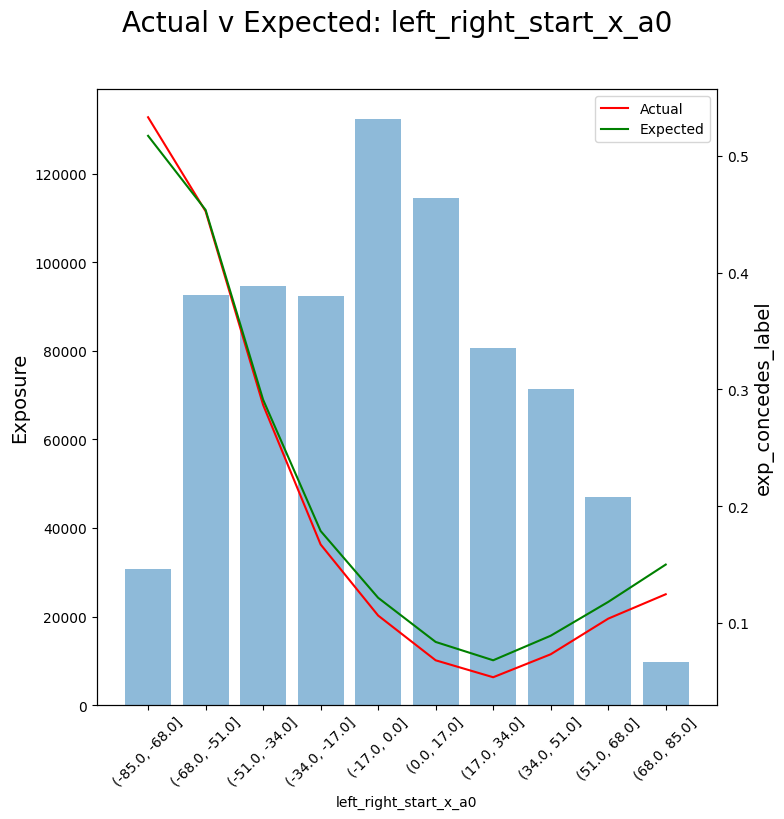

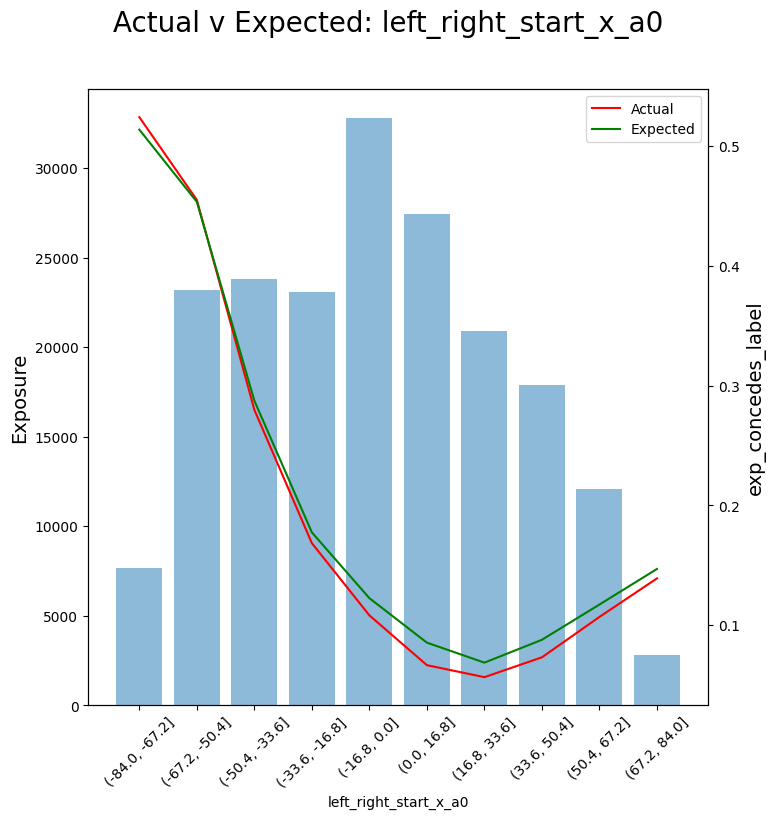

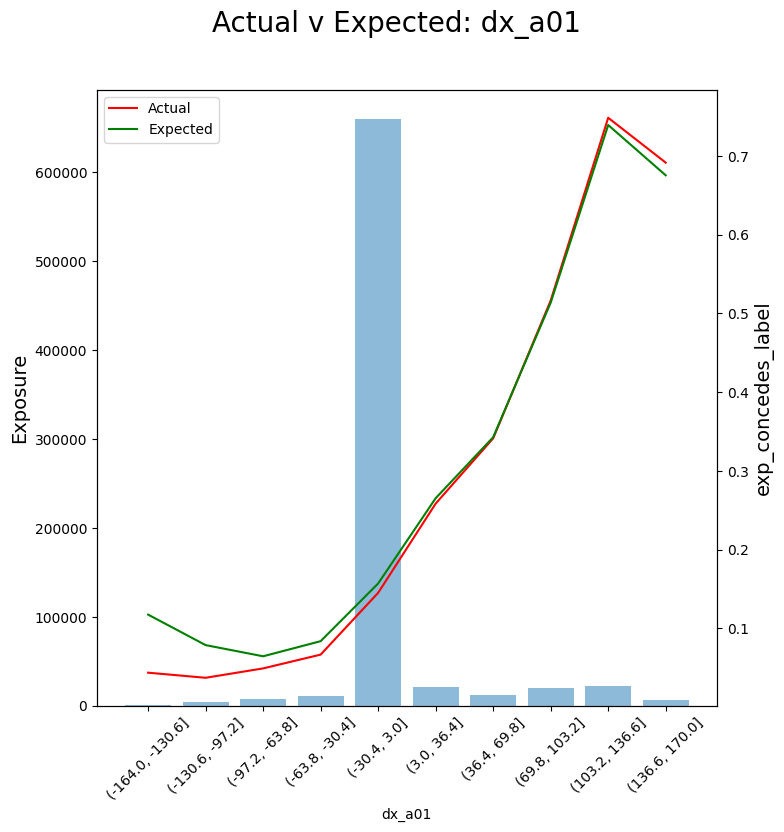

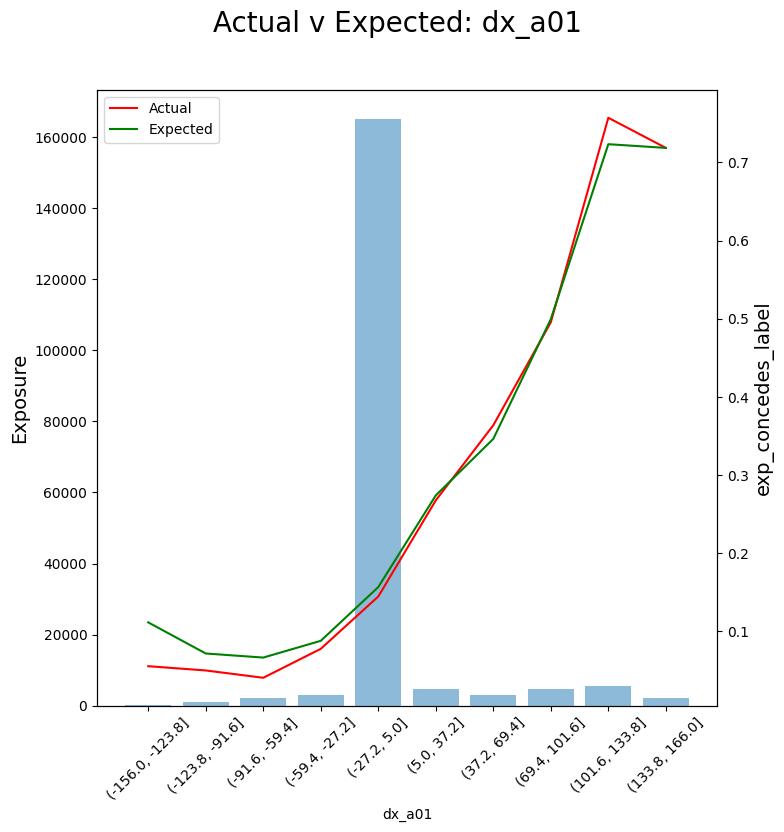

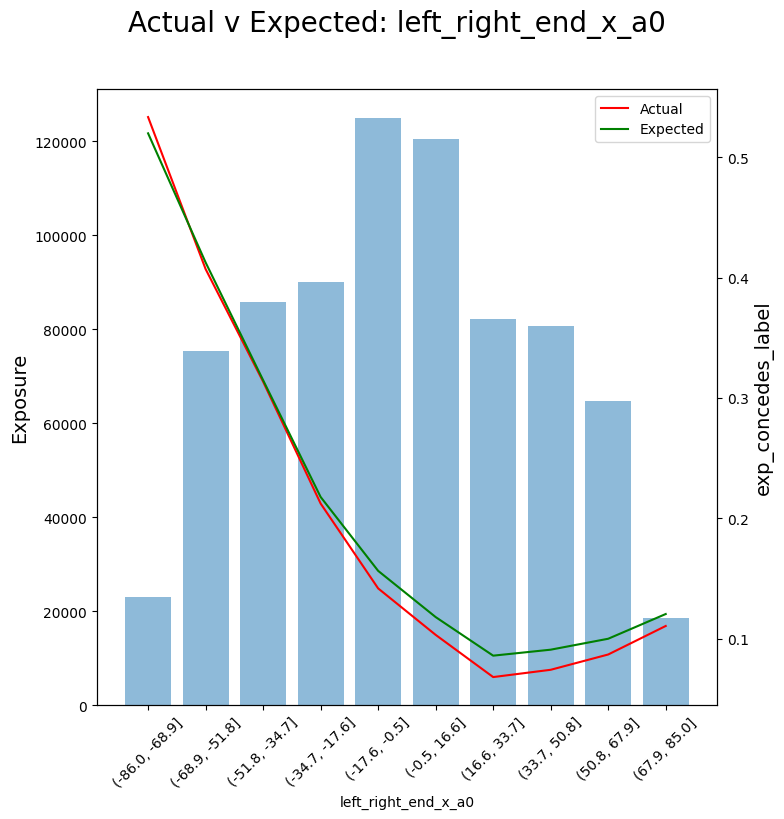

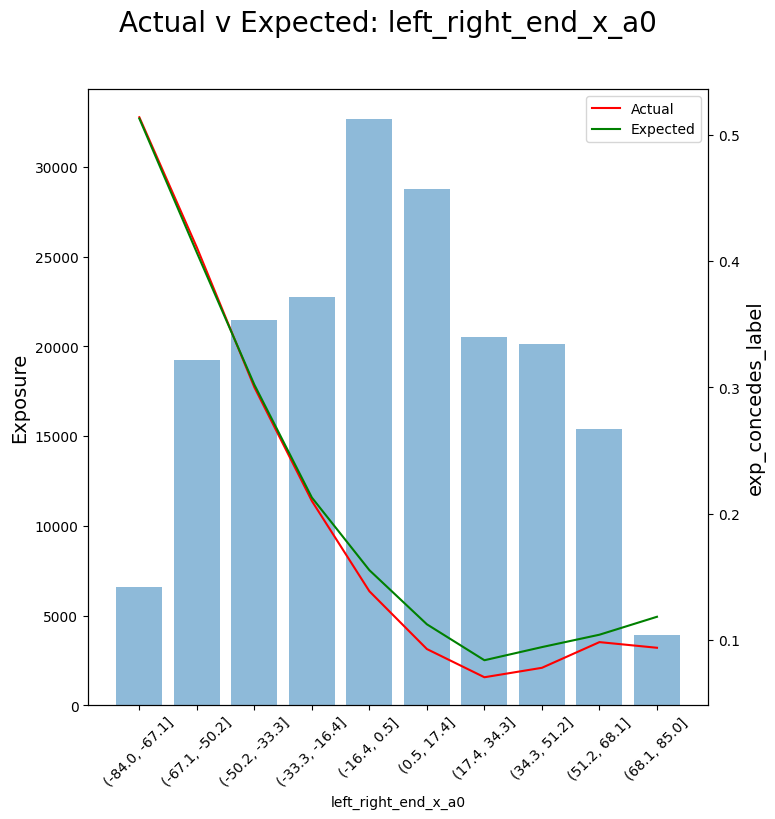

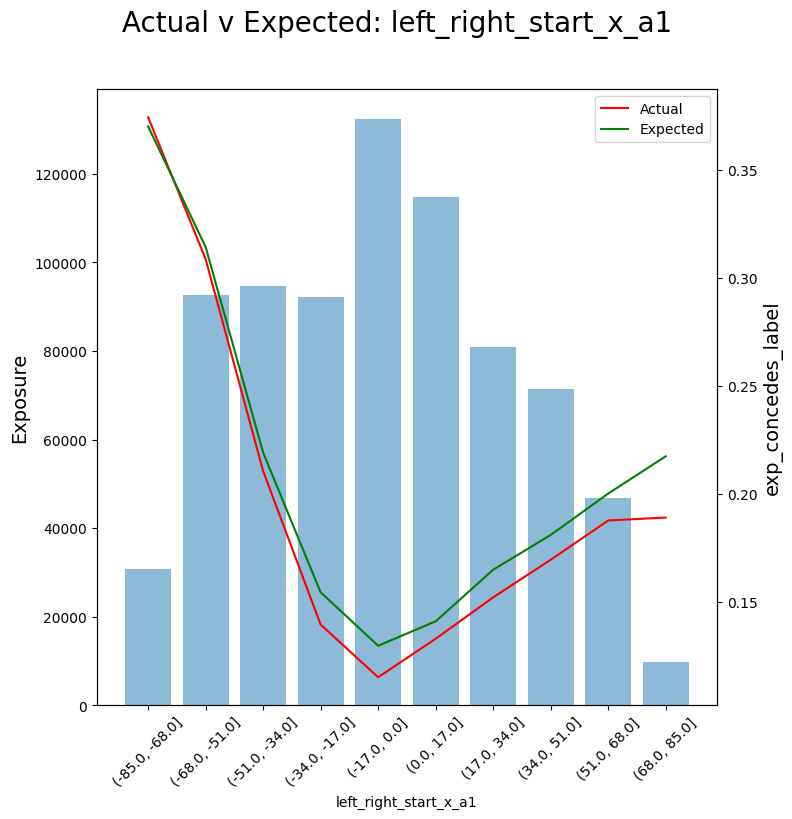

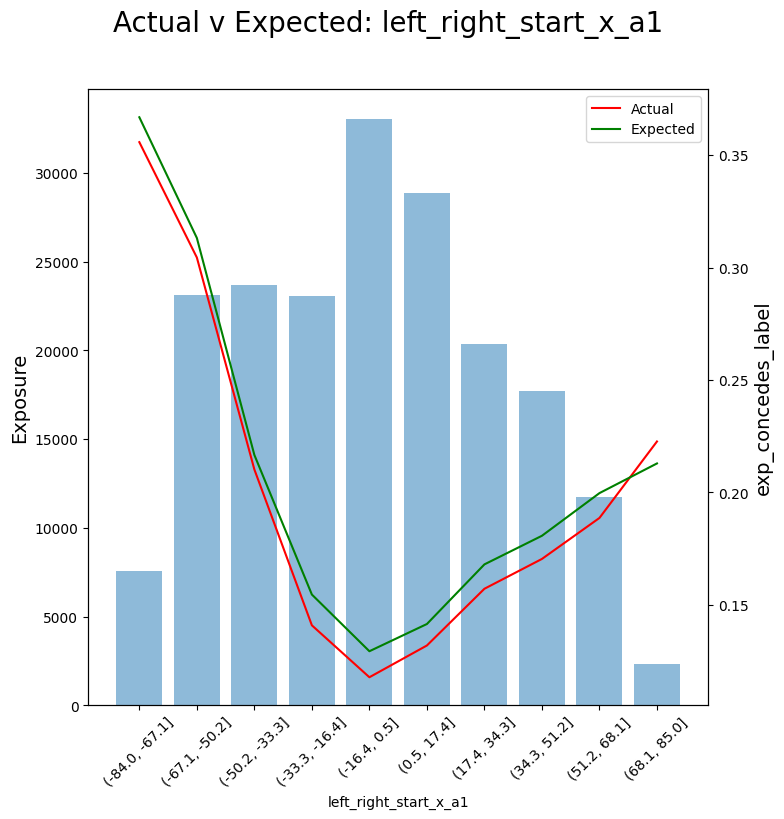

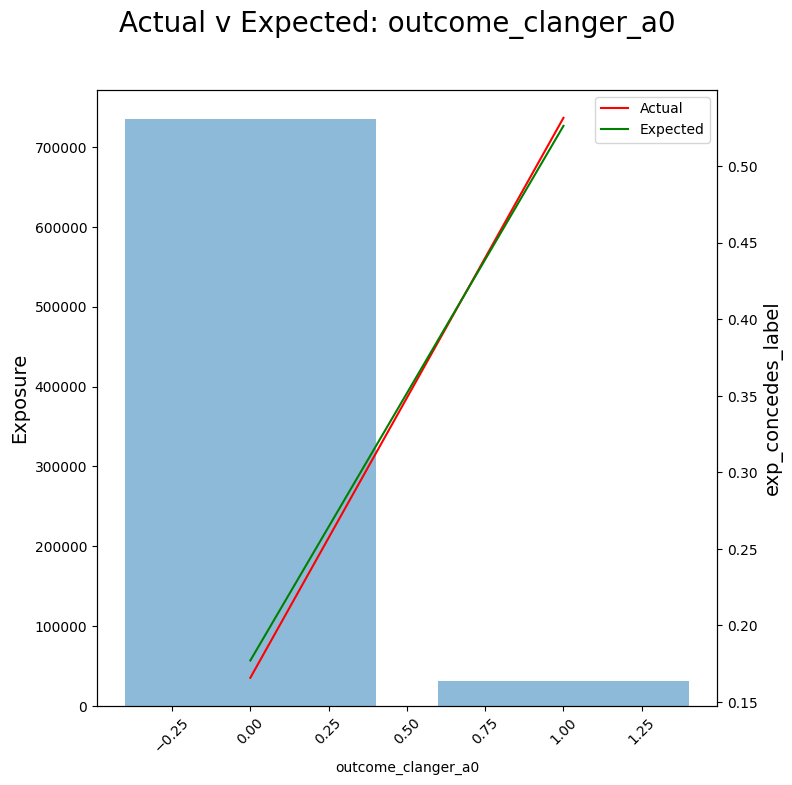

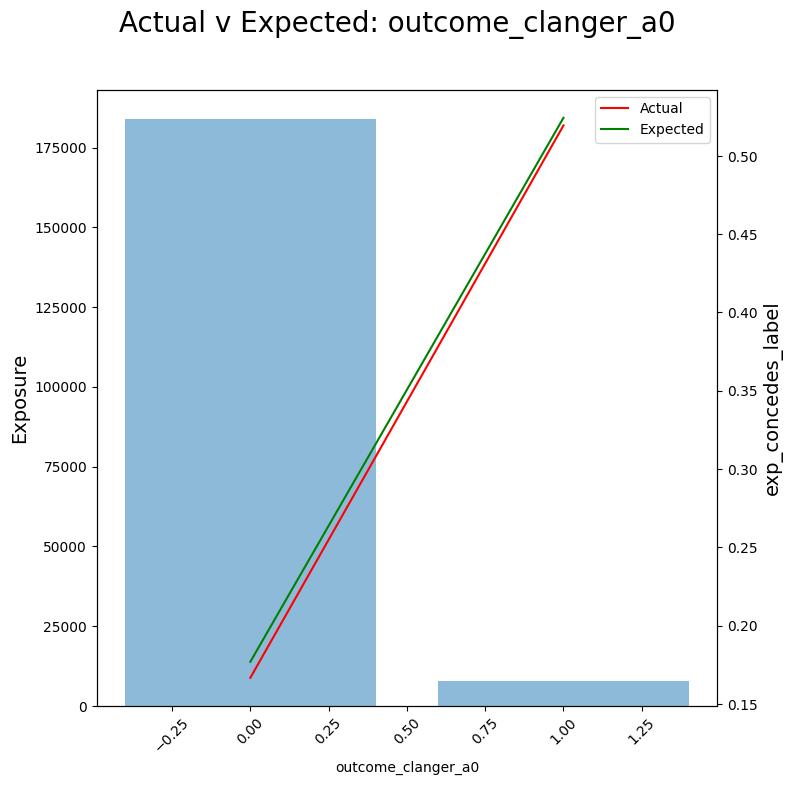

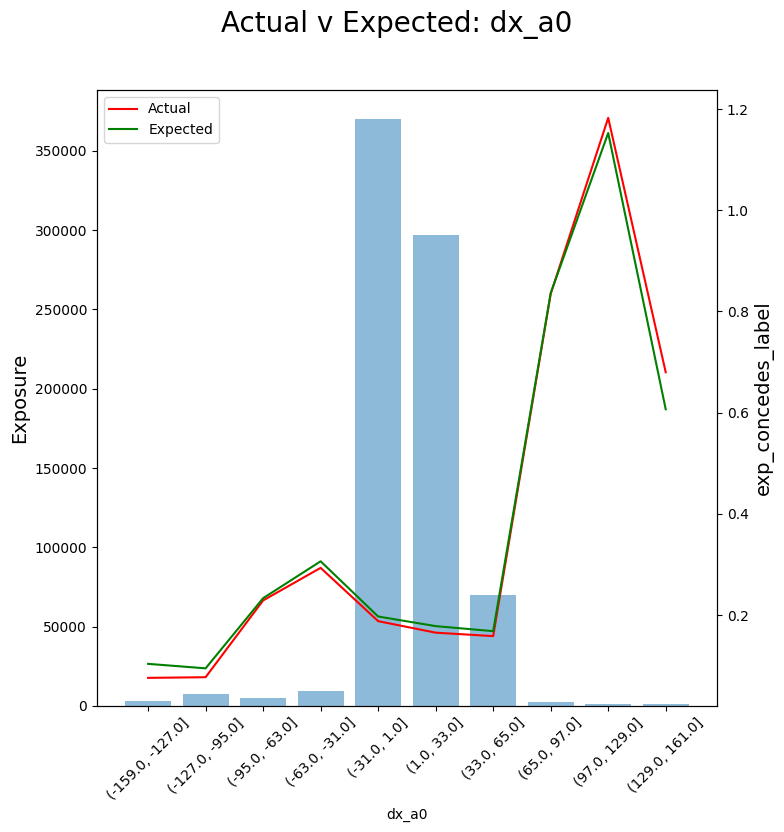

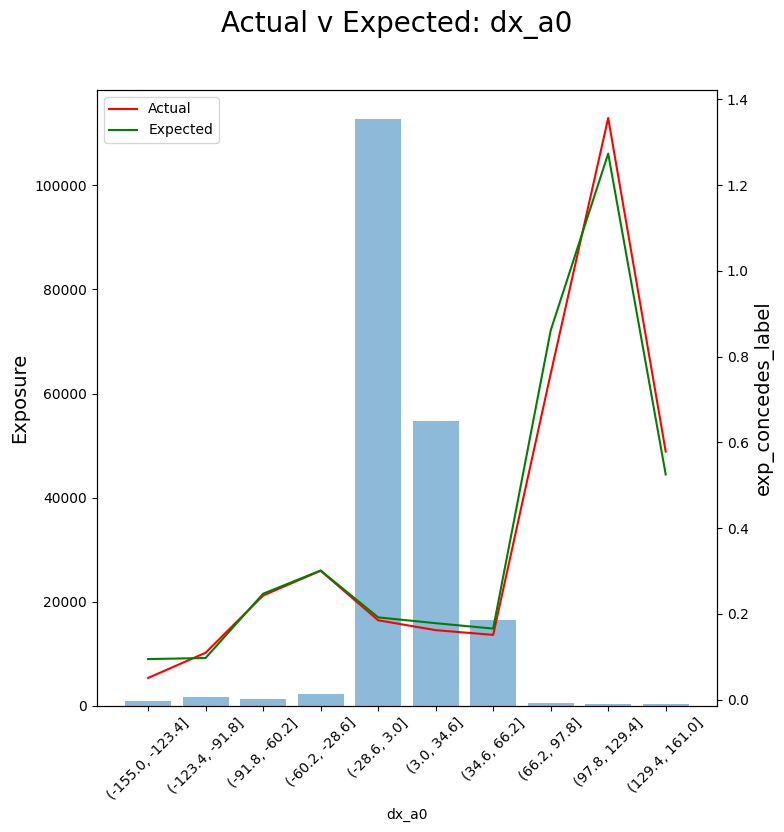

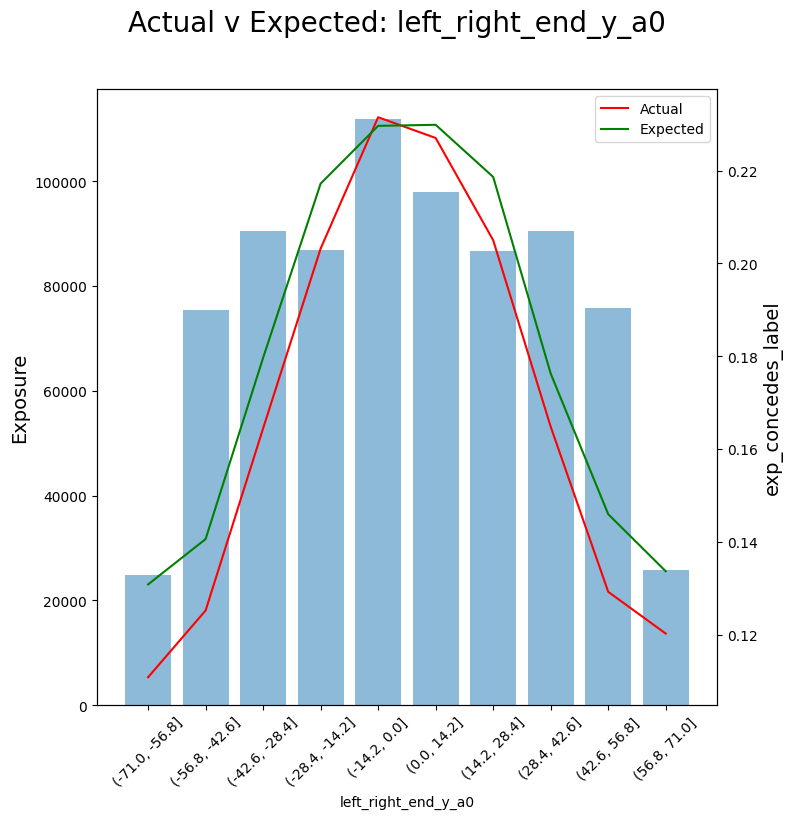

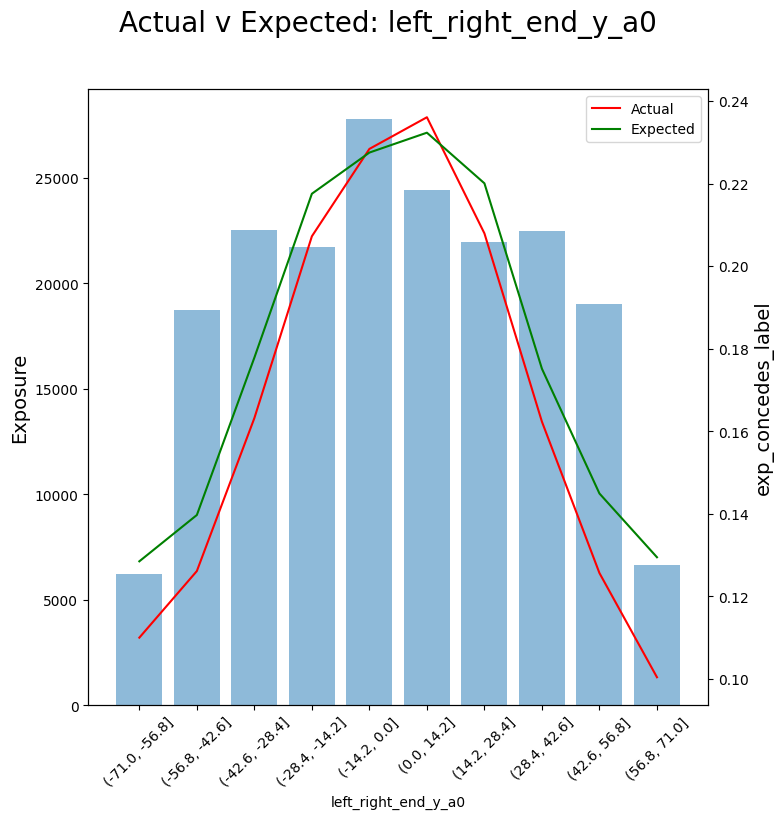

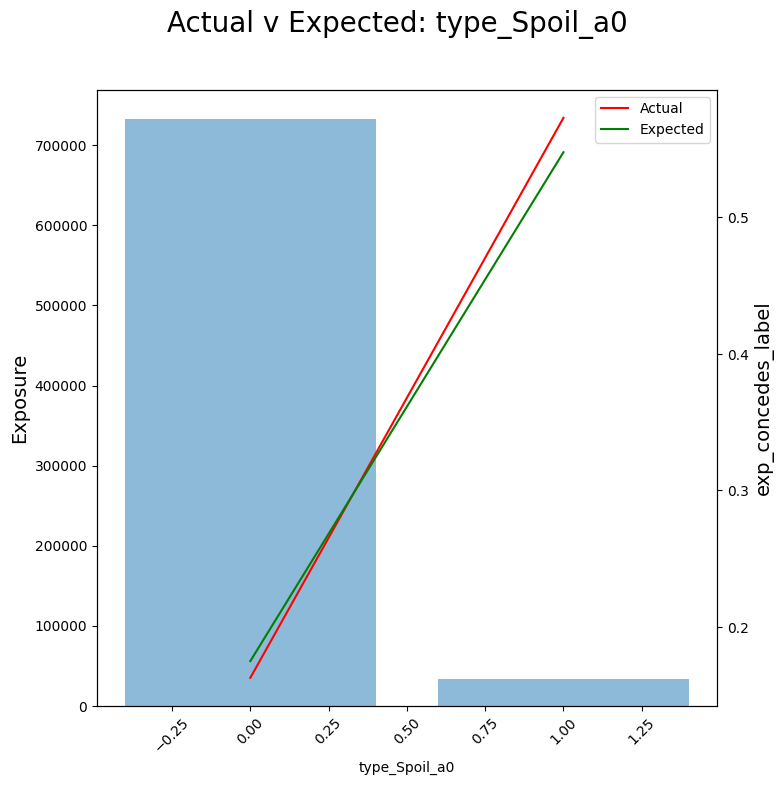

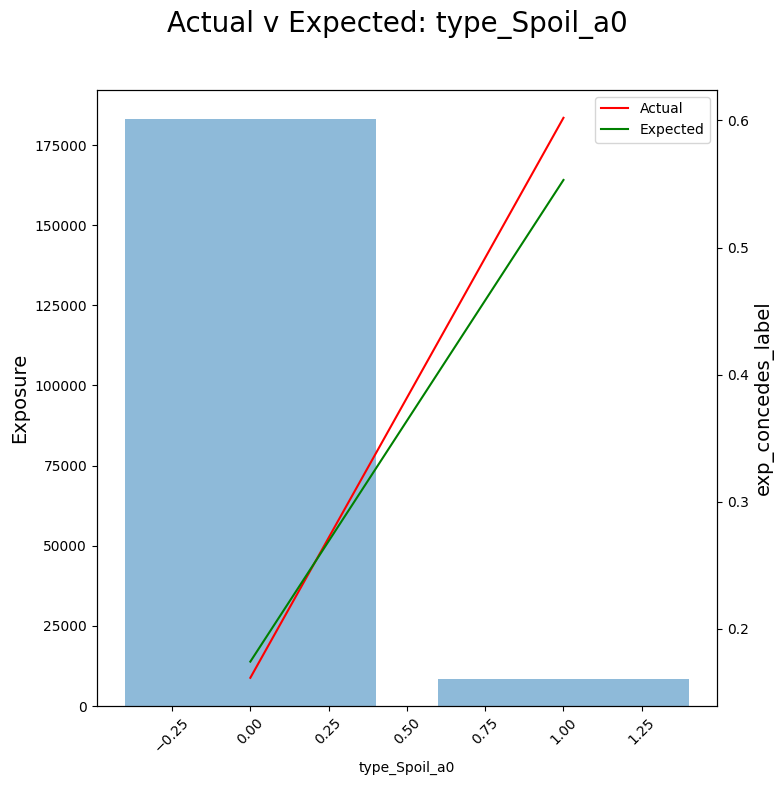

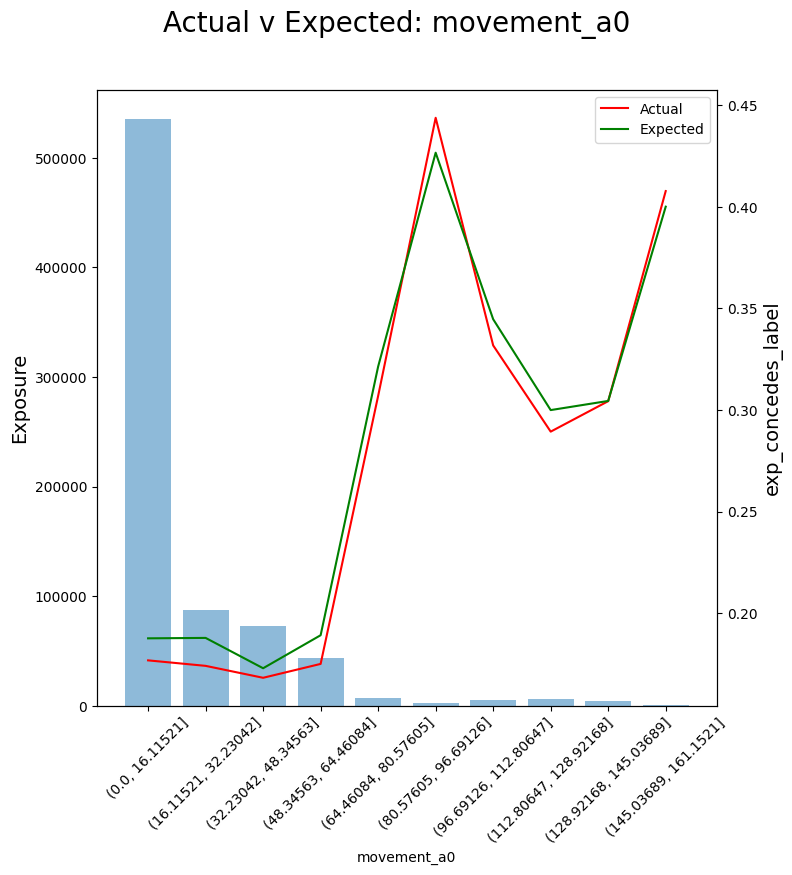

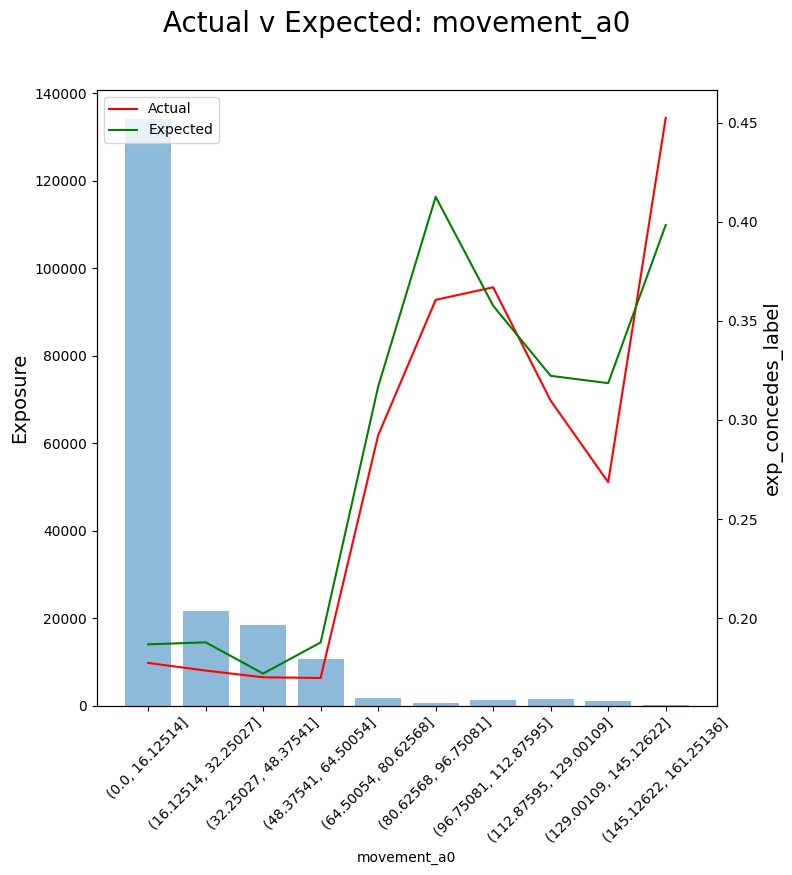

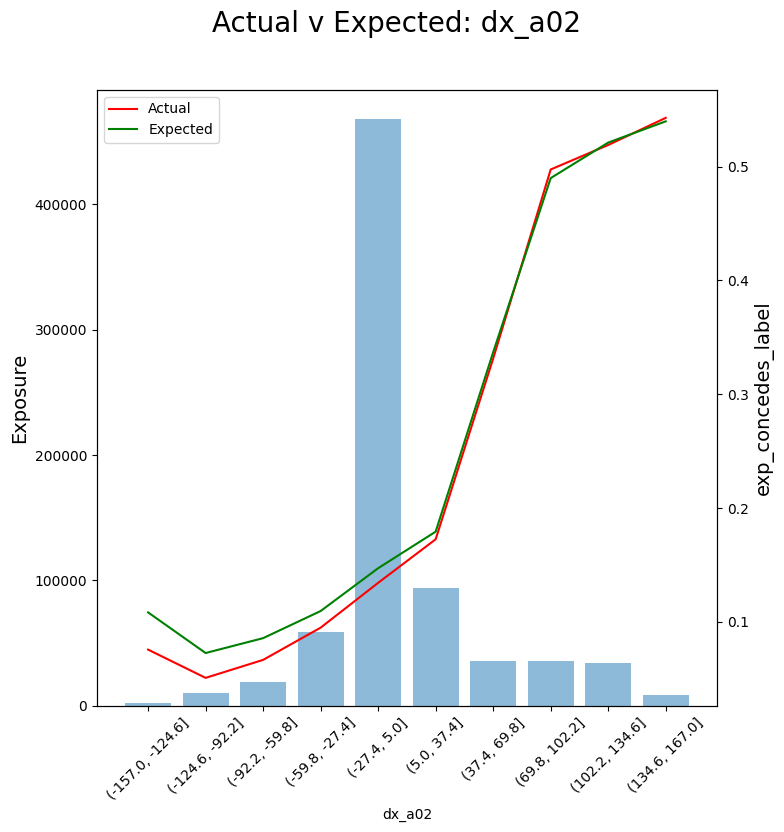

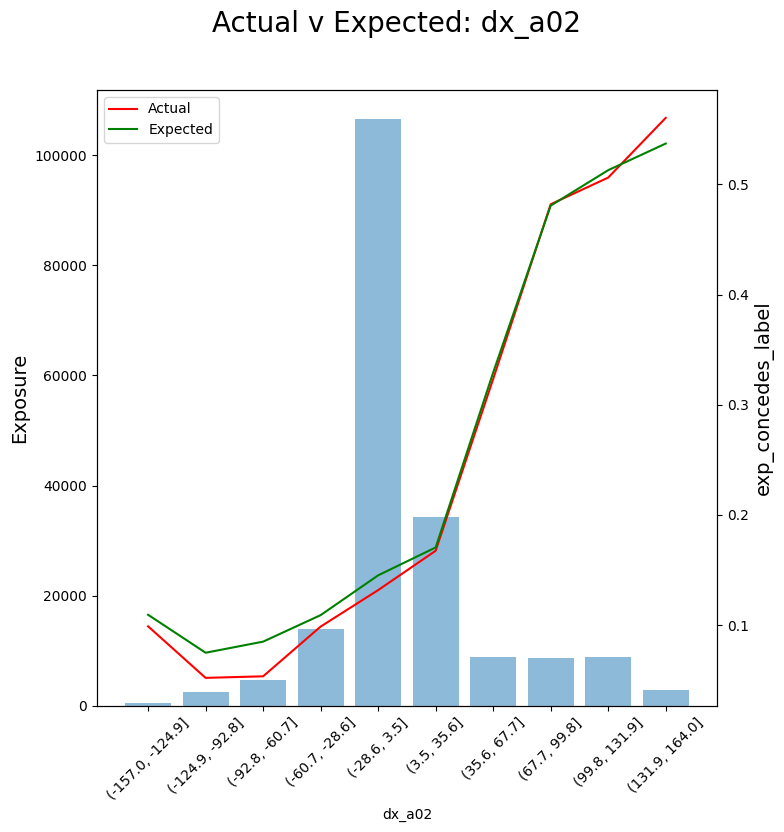

In [31]:
for col in top_10_features:
    concedes_train_evals.plot_feature_ave(col)
    concedes_test_evals.plot_feature_ave(col)

Model Metrics

In [32]:
scores_train_evals.get_mae(), scores_test_evals.get_mae()

(0.8119273522453332, 0.8216549066318853)

In [33]:
scores_train_evals.get_mse(), scores_test_evals.get_mse() 

(1.5207967225685937, 1.5558776172459627)

In [34]:
scores_train_evals.get_r2_score(), scores_test_evals.get_r2_score() 

(0.3652253504428957, 0.350496050092892)

In [35]:
concedes_train_evals.get_mae(), concedes_test_evals.get_mae()

(0.3063565089718487, 0.31023292276376924)

In [36]:
concedes_train_evals.get_mse(), concedes_test_evals.get_mse() 

(0.534910241867093, 0.5526472814274405)

In [37]:
concedes_train_evals.get_r2_score(), concedes_test_evals.get_r2_score() 

(0.12419930270300239, 0.09897793615949035)